In [1]:
import numpy as np
import pandas as pd
import comonotonic as cm
import os
from sklearn.model_selection import train_test_split
import copy
import utils
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Note that we assume the last column is the label
# If the first column is ID's, remove it
filename = "adult.csv"
random_state = 24
df = pd.read_csv("Datasets/"+filename)
# education and education.num is actually the same, so drop "education"
df = df.drop(['education'], axis=1)
colnames = [('X'+str(i)) for i in range(df.shape[1]-1)]
colnames.append('Y')
df.columns = colnames

In [3]:
colname_dict = {'X0':"age", 'X1': 'workclass', 'X2': 'fnlwgt', 'X3': 'education.num', 'X4': 'marital.status', 'X5': 'occupation', 'X6': 'relationship',
               'X7': 'race', 'X8': 'sex', 'X9': 'capital.gain', 'X10': 'capital.loss', 'X11': 'hours.per.week', 'X12': 'native.country', 'Y': 'income'}

In [4]:
#data cleaning for adult.csv
df = df[df.X1 != '?']
df = df[df.X6 != '?']
# unrankable features
encoded_df = utils.encode_df(df, [1,4,5,6,7,8,12,13])
encoded_df = encoded_df.astype('int32')
# continuous variables; categorical rankable features are [3]
cont_col = [0,2,9,10,11]
num_categories_list = [3,4,5,6,7,8,9,10]
# unrankable columns
unrankable = [1,4,5,6,7,8,12]
unrankable_fv = {k:encoded_df['X'+str(k)].nunique() for k in unrankable}


# Normalize continuous features and then discretize into equal length bins

In [5]:
normalized_df = encoded_df.copy()
utils.normalize_df_col(normalized_df, cont_col)

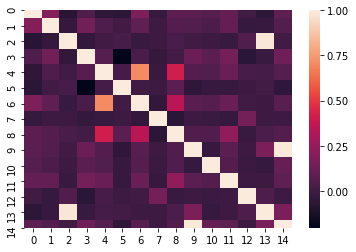

In [6]:
# make sure whether it is proper to construct some columns by yourself

test_df = encoded_df.copy()
test_df = test_df.drop(['Y'], axis = 1)
test_df['X13'] = test_df.apply(lambda row: 0.2*row.X2+0.5*row.X9-row.X10, axis = 1)
test_df['X14'] = test_df.apply(lambda row: 1.4*row.X9+3.8*row.X10, axis = 1)
X = test_df.to_numpy()

corr = np.corrcoef(X.T)
ax = sns.heatmap(corr)


/Users/pengcheng/Desktop/FYP/Improvement-to-Naive-Bayes-Classifier/utils.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_df['X'+str(col_idx)] = discretized_col
/Users/pengcheng/Desktop/FYP/Improvement-to-Naive-Bayes-Classifier/utils.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_df['X'+str(col_idx)] = discretized_col_test


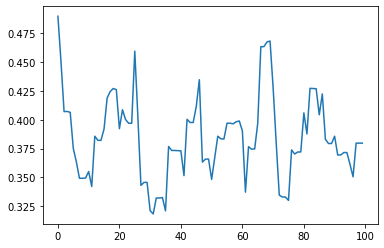

In [43]:
# Here encounters the combinatorial optimization problem
# suppose cont_col has size m, num_categories_list has size n, then there are n^m combinations
# need to use some combinatorial optimization method to find the optimal combination
df1 = normalized_df.copy()
accuracy_history1, allocation_history1 = utils.determine_allocation(cont_col, num_categories_list,
                                                               df1, unrankable_fv, colnames, max_itr = 100,
                                                               temp = 2, anneal_schedule = 5, use_cluster = False,
                                                               use_mistaken_accuracy_test = False, random_state = random_state)
plt.plot(list(accuracy_history1.values()))

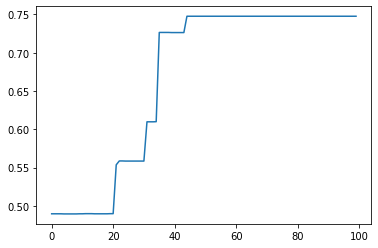

In [44]:
df2 = normalized_df.copy()
accuracy_history2, allocation_history2 = utils.determine_allocation(cont_col, num_categories_list,
                                                               df2, unrankable_fv, colnames, max_itr = 100,
                                                               temp = 2, anneal_schedule = 5, use_cluster = False,
                                                               use_mistaken_accuracy_test = True, random_state = random_state)
plt.plot(list(accuracy_history2.values()))

# Not normalize continuous columns, discretize into equal size bins

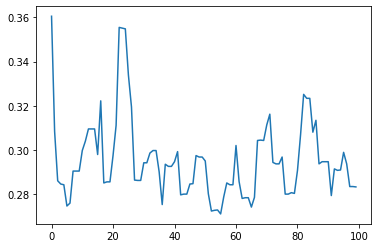

In [6]:
df3 = encoded_df.copy()
accuracy_history3, allocation_history3 = utils.determine_allocation(cont_col, num_categories_list,
                                                               df3, unrankable_fv, colnames, max_itr = 100,
                                                               temp = 2, anneal_schedule = 5, use_cluster = False,
                                                               use_mistaken_accuracy_test = False, random_state = random_state, qcut = True)
plt.plot(list(accuracy_history3.values()))

In [6]:
df = encoded_df.copy()
try:
    discretized_col, bins = pd.qcut(df.iloc[:,9],2, 
                                                labels=[i for i in range(2)], 
                                                retbins=True, duplicates = 'drop')
except:
    discretized_col, bins = ("haha", "xixi")

In [5]:
# comparation with Naive Bayes
# use the original data for Naive Bayes
original_X = encoded_df[colnames[:-1]].to_numpy()
original_Y = encoded_df[colnames[-1]].to_numpy()
original_X_train, original_X_test, original_Y_train, original_Y_test = train_test_split(original_X, original_Y, test_size=0.2, 
                                                                                        random_state=random_state)

In [6]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(original_X_train, original_Y_train)
pred = model.predict(original_X_test)
utils.get_accuracy(pred, original_Y_test)

0.7912123677786819

In [7]:
# implementation of NB from scratch
nb_classifier = cm.naive_bayes(original_X_train, original_Y_train, cont_col)
nb_classifier.run()
nb_y_predict = nb_classifier.predict(original_X_test)
utils.get_accuracy(nb_y_predict, original_Y_test)

0.8185516680227828

In [8]:
# clustered comonotonic
df_for_cluster = encoded_df.copy()
#continuous variables; categorical rankable features are [3]
cluster_accuracy_history, cluster_allocation_history = utils.determine_allocation(cont_col, num_categories_list,
                                                               df_for_cluster, unrankable_fv,
                                                               colnames, max_itr = 30, temp = 2,
                                                               anneal_schedule = 2, use_cluster = True,
                                                               use_mistaken_accuracy_test = False, 
                                                               random_state = random_state, min_corr = 0.7)

/Users/pengcheng/Desktop/FYP/Improvement-to-Naive-Bayes-Classifier/utils.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_df['X'+str(col_idx)] = discretized_col
/Users/pengcheng/Desktop/FYP/Improvement-to-Naive-Bayes-Classifier/utils.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_df['X'+str(col_idx)] = discretized_col_test


In [9]:
cluster_acc_history = list(cluster_accuracy_history.values())
allocation_idx = cluster_acc_history.index(max(cluster_acc_history))

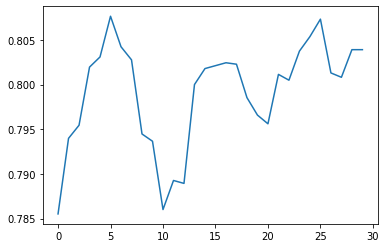

In [10]:
plt.plot(list(cluster_accuracy_history.values()))

In [11]:
# clustered comonotonic validation
allocation_book_cluster = cluster_allocation_history[allocation_idx]
como_cluster_df = encoded_df.copy()
uncategorized_df = encoded_df.copy()
feature_val = utils.merge_dict(unrankable_fv, allocation_book_cluster)
for col in range(como_cluster_df.shape[1]-1):
    if col not in feature_val.keys():
        feature_val[col] = df['X'+str(col)].nunique()
        
for col_idx in allocation_book_cluster.keys():
    discretized_col = pd.cut(como_cluster_df.iloc[:,col_idx],allocation_book_cluster[col_idx], labels=[i for i in range(allocation_book_cluster[col_idx])])
    como_cluster_df['X'+str(col_idx)] = discretized_col
X_cluster = como_cluster_df[colnames[:-1]].to_numpy()
Y_cluster = como_cluster_df[colnames[-1]].to_numpy()
X_train_cluster, X_test_cluster, Y_train_cluster, Y_test_cluster = train_test_split(X_cluster, Y_cluster, 
                                                                                    test_size=0.2, random_state=random_state)

como_cluster_classifier = cm.clustered_comonotonic(X_train_cluster, Y_train_cluster, unrankable, feature_val, uncategorized_df, 
                                                   colnames, min_corr = 0.6, random_state = random_state)
como_cluster_classifier.run()
Y_cluster_pred = como_cluster_classifier.predict(X_test_cluster)
utils.get_accuracy(Y_cluster_pred, Y_test_cluster)

0.8076484947111473

In [17]:
# weighted average of naive bayes and cluster comonotonic
weighted_predict_y = []
for i in range(len(X_test_cluster)):
    prob_dist_cluster_como = como_cluster_classifier.get_prob_dist_single(X_test_cluster[i])
    predicted_class, prob_dist_nb = nb_classifier.predict_single(original_X_test[i])
    weighted_predict_y.append(utils.weighted_avg(prob_dist_nb, prob_dist_cluster_como, 0.7))
#     print(prob_dist_cluster_como)
#     print(prob_dist_nb)
#     print("------")
print(utils.get_accuracy(weighted_predict_y, Y_test_cluster))

0.8310821806346623
